In [1]:
# Setup HAN prior running here:
# $ git clone https://github.com/FlorisHoogenboom/keras-han-for-docla
# $ cd keras-han-for-docla
# $ pip install .

import warnings
import numpy as np
import gc
import json
import h5py

import tensorflow as tf
from keras.utils import Sequence
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.sequence import _remove_long_seq
from keras.models import Sequential
from keras.layers import Embedding, Input, Dense, Dropout
from keras import metrics
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_han.model import HAN
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

gpu_options = tf.GPUOptions(
    per_process_gpu_memory_fraction=0.65, allow_growth=False)
config = tf.ConfigProto(intra_op_parallelism_threads=16,
                        inter_op_parallelism_threads=16, allow_soft_placement=True, gpu_options=gpu_options)
session = tf.Session(config=config)
K.set_session(session)


Using TensorFlow backend.


In [2]:
def load_vocab():
    with open('data/ams_word_index.json') as json_data:
        return json.load(json_data)

def load_index_vocab():
    index_vocab = {}
    with open('data/ams_word_index.json') as json_data:
        for word, index in json.load(json_data).items():
            index_vocab[index] = word
    return index_vocab

    
def load_glove():
    glove = {}
    with open('data/glove.model.txt') as glove_data:
        for line in glove_data:
            items = line.split()
            key = items[0]
            glove[key] = np.asarray(items[1:], dtype='float32')
    return glove

In [3]:
# Data-management before main training

# Input data is obtained via batch loading from HDF5
class DataGenerator(Sequence):
    def __init__(self, batch_size=128, mode="train", dim=480, max_sent_words = 20, max_sents = 24,
             n_classes=13, x_hf = None, y_hf = None, shuffle=False, cap=None):
        'Initialization'
        self.x_hf = x_hf
        self.y_hf = y_hf
        self.mode = mode
        self.max_sent_words = max_sent_words
        self.max_sents = max_sents
        if cap:
            if cap>1:
                self.total_len = cap
            if cap>0 and cap<1:
                self.total_len = int(cap * self.y_hf.shape[0])
        else:
            self.total_len = self.y_hf.shape[0]
        self.validation_len = int(np.ceil(0.1 * self.total_len))
        self.training_len = self.total_len - self.validation_len
        if self.mode == "validation":
            self.data_len = self.validation_len
            self.list_IDs = np.arange(self.training_len, self.total_len)
        else:
            self.data_len = self.training_len
            self.list_IDs = np.arange(0,self.training_len+1)
            
        self.dim = dim
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end() 

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples,  dim)
        # Initialization
        X = np.empty((self.batch_size, self.max_sents, self.max_sent_words), dtype=int)
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # Also reshape x to a "24 sentences of 20 words" shape
            X[i,] = self.x_hf[ID].reshape(self.max_sents, self.max_sent_words)
            # Store class
            y[i] = self.y_hf[ID]
        
        return X, y
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

batch_size = 128
# Parameters
data_hf = h5py.File("data/confusion_free_ams.hdf5", 'r')


In [4]:
# preparing word embeddings
# Takes 10 minutes to recompute, memoizing here for the v4 49 class variant:
# class_weights = compute_class_weight('balanced', np.unique(training_generator.y_hf), training_generator.y_hf)
# np.set_printoptions(precision=32, suppress=True)
# print(class_weights)

class_weights = [
    0.7792753391061454, 4.951332154253932, 2.001955500852656,
    1.1697059411613484, 2.721513181042234, 1.16662253697677,
    513.2617350700418,  0.373816961226278, 0.19784541616346885,
    13.943577058275665, 30.542000584966363, 1.2482589205666128,
    3.348237013321448 ]

n_classes = 13

In [5]:
def build_embedding_matrix(vocab_dim=300):
    print("-- loading word embeddings, this may take a little while...")
    index_dict = load_vocab()
    word_vectors = load_glove()
    # adding 1 to account for 0th index (for masking)
    n_symbols = len(index_dict) + 1
    print("-- known dictionary items: ", n_symbols)
    embedding_weights = np.zeros((n_symbols, vocab_dim))
    embedding_weights[0] = 0
    for word, index in index_dict.items():
        embedding_weights[index, :] = word_vectors[word]
    return embedding_weights

embedding_matrix = build_embedding_matrix(vocab_dim=300)


-- loading word embeddings, this may take a little while...
-- known dictionary items:  1000296


In [7]:
# HAN Model Setup
print("-- setting up model layout...")
model_file = "han_batch%d_cat%d_gpu" % (batch_size, n_classes)
# stop early when metric stops improving
earlystop = EarlyStopping(monitor='val_weighted_sparse_categorical_accuracy',
                          min_delta=0.001,
                          patience=3,
                          verbose=1, mode='auto')

def han_model(generator_params):
    # Generators
    training_generator = DataGenerator(**generator_params)
    validation_generator = DataGenerator(mode="validation", **generator_params)
    # Prepare model
    model = HAN(
        generator_params['max_sent_words'], generator_params['max_sents'], n_classes, embedding_matrix,
        word_encoding_dim=300, sentence_encoding_dim=300
    )

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer="adam",
                  weighted_metrics=[metrics.sparse_categorical_accuracy])

    # Print model summary
    print(model.summary())

    # Perform training
    print('-- training model...')
    out = model.fit_generator(
        generator=training_generator,
        validation_data=validation_generator,
        workers = 1,
        use_multiprocessing=False,
        class_weight=class_weights,
        epochs=50,
        verbose=1,
        callbacks=[earlystop])
    return out, model

# for (max_sents, max_sent_words) in [(5,96),(8,60),(10,48)]:
max_sents = 8
max_sent_words = 60
generator_params = {
    'batch_size': batch_size,
    'n_classes': 13,
#     'cap': 0.03,
    'shuffle': True,
    'max_sents': max_sents,
    'max_sent_words': max_sent_words,
    'x_hf': data_hf['x_train'],
    'y_hf': data_hf['y_train']
}
(out, model) = han_model(generator_params)
# print("(sents %d; words %d) result: " % (max_sents, max_sent_words))
# print(np.mean(out.history['val_weighted_sparse_categorical_accuracy']))

-- setting up model layout...
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 60)             0         
_________________________________________________________________
word_encoder (TimeDistribute (None, 8, 60, 300)        300494700 
_________________________________________________________________
word_attention (TimeDistribu (None, 8, 300)            30100     
_________________________________________________________________
sentence_encoder (Model)     (None, 8, 300)            405900    
_________________________________________________________________
sentence_attention (Attentio (None, 300)               30100     
_________________________________________________________________
class_prediction (Dense)     (None, 13)                3913      
Total params: 300,964,713
Trainable para

/home/deyan/.local/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222942). Check your callbacks.
  % delta_t_median)
/home/deyan/.local/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111932). Check your callbacks.
  % delta_t_median)


58738/58738 [==============================] - 9338s 159ms/step - loss: 0.2997 - weighted_sparse_categorical_accuracy: 0.9051 - val_loss: 0.3346 - val_weighted_sparse_categorical_accuracy: 0.8940
Epoch 3/50
58738/58738 [==============================] - 9272s 158ms/step - loss: 0.3050 - weighted_sparse_categorical_accuracy: 0.9031 - val_loss: 0.3629 - val_weighted_sparse_categorical_accuracy: 0.8845
Epoch 4/50
58738/58738 [==============================] - 9312s 159ms/step - loss: 0.3271 - weighted_sparse_categorical_accuracy: 0.8957 - val_loss: 0.3658 - val_weighted_sparse_categorical_accuracy: 0.8834
Epoch 00004: early stopping


In [8]:
# save model weights
# CAUTION: a regular model .save, including a checkpoint, seemed to produce an error??
#          .save_weights works better...
print("-- saving model weights to disk : %s " % model_file)
model.save_weights(model_file+'_notebook.h5')

-- saving model weights to disk : han_batch128_cat13_gpu 


In [14]:
print("Per-class test measures:")
x_test = [x.reshape(8,60) for x in data_hf["x_test"]]
y_prob = model.predict(np.array(x_test), batch_size=batch_size, verbose=1)
y_pred = y_prob.argmax(axis=-1)

print(classification_report(data_hf["y_test"], y_pred))



Per-class test measures:
2088449/2088449 [==============================] - 782s 374us/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92    206155
           1       0.99      0.99      0.99     32445
           2       0.86      0.69      0.77     80246
           3       0.85      0.86      0.86    137342
           4       0.75      0.52      0.61     59029
           5       0.81      0.91      0.85    137706
           6       0.81      0.71      0.76       313
           7       0.90      0.92      0.91    429756
           8       0.94      0.96      0.95    811998
           9       0.85      0.77      0.81     11521
          10       0.75      0.57      0.65      5259
          11       0.75      0.67      0.71    128699
          12       0.78      0.71      0.74     47980

   micro avg       0.89      0.89      0.89   2088449
   macro avg       0.84      0.79      0.81   2088449
weighted avg       0.89      0.89      0.8

Note that the data of 480 max-words per paragraph is reshaped to a fixed 8 sentences of 60 words each (padded with 0 for missing entries), and hence does *not* use the real sentence breaks from tokenization - a possible direction for improvement. The split was found by grid search on 3% of the final data.

## Test HAN(8;60), 13-class task

```
Per-class test measures:
2088449/2088449 [==============================] - 782s 374us/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92    206155
           1       0.99      0.99      0.99     32445
           2       0.86      0.69      0.77     80246
           3       0.85      0.86      0.86    137342
           4       0.75      0.52      0.61     59029
           5       0.81      0.91      0.85    137706
           6       0.81      0.71      0.76       313
           7       0.90      0.92      0.91    429756
           8       0.94      0.96      0.95    811998
           9       0.85      0.77      0.81     11521
          10       0.75      0.57      0.65      5259
          11       0.75      0.67      0.71    128699
          12       0.78      0.71      0.74     47980

   micro avg       0.89      0.89      0.89   2088449
   macro avg       0.84      0.79      0.81   2088449
weighted avg       0.89      0.89      0.89   2088449

```
     

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sn

np.set_printoptions(precision=2)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        annot = True
        print("Normalized confusion matrix")
    else:
        annot = False
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(50,40))
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=annot)

Normalized confusion matrix


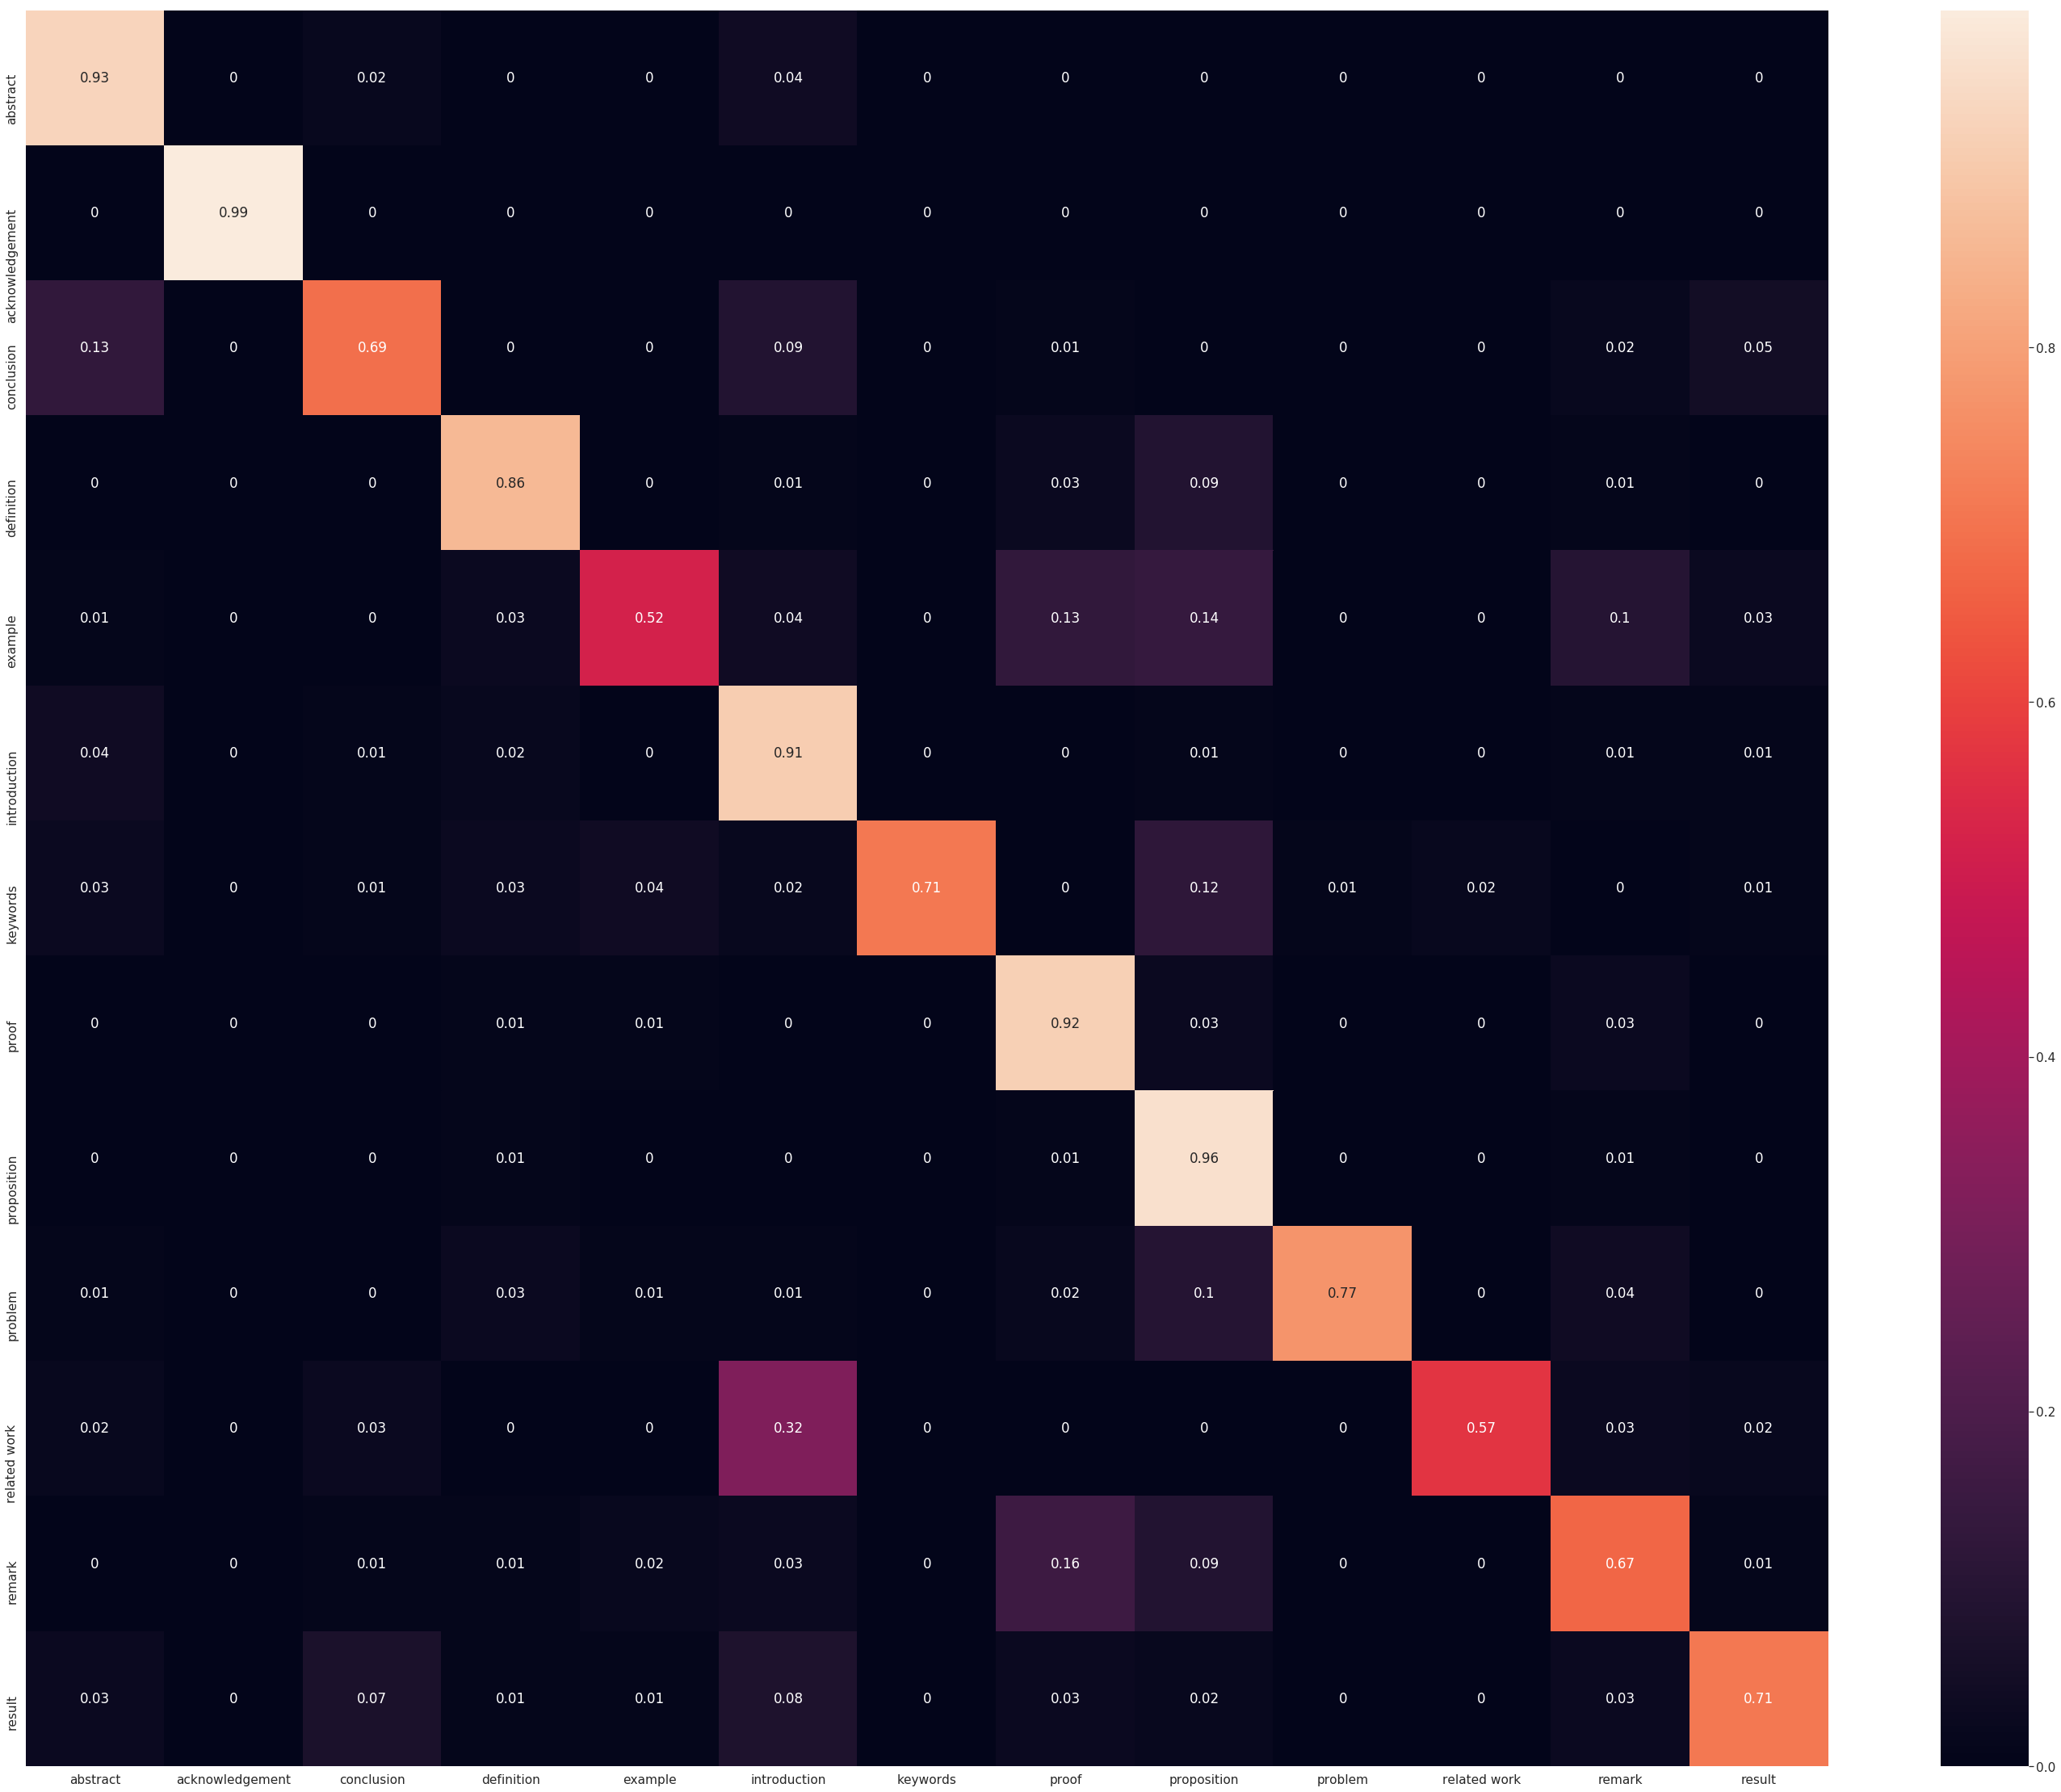

In [25]:
# Plot non-normalized confusion matrix
class_names = [
    'abstract', 'acknowledgement', 'conclusion', 'definition', 'example',
    'introduction', 'keywords', 'proof', 'proposition', 'problem', 'related work', 'remark', 'result']

# Plot normalized confusion matrix
plot_confusion_matrix(data_hf['y_test'], y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')